<h1 align="center"> Supervised Decision Tree</h1>

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import PIL
import torchvision.transforms as transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score,multilabel_confusion_matrix
import cv2
from tensorflow import keras
from keras_tuner.engine.hyperparameters import HyperParameters
from keras import layers, models, regularizers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.semi_supervised import LabelPropagation
from torchstat import stat
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import joblib

<hr style="border: 2px solid;">

<h3 align="center">  DATA LOADING AND SPLITING DATA

In [2]:
# Appending labels according to the file names
file = []
labels = []
resized_image = []
for dirname,_, filenames in os.walk('lung_colon_image_set'):
    for filename in filenames:
        if not filename.lower().endswith('.ds_store'):
            if "lung_aca" in dirname:
                labels.append("Lung Adenocarcinoma")
            elif "lung_n" in dirname:
                labels.append("Lung Benign Tissue")
            elif "lung_scc" in dirname:
                labels.append("Lung Squamous Cell Carcinoma")
            elif "colon_n" in dirname:
                labels.append("Colon Benign Tissue")
            elif "colon_aca" in dirname:
                labels.append("Colon Adenocarcinoma")
            file.append(os.path.join(dirname, filename))

In [3]:
Slabels = pd.Series(labels,name="Labels")
Sfile  = pd.Series(file,name="Filepaths")
data = pd.concat([Sfile,Slabels],axis=1)

In [4]:
data.head()

,Filepaths,Labels
0,lung_colon_image_set/lung_aca/lungaca2296.jpeg,Lung Adenocarcinoma
1,lung_colon_image_set/lung_aca/lungaca1843.jpeg,Lung Adenocarcinoma
2,lung_colon_image_set/lung_aca/lungaca294.jpeg,Lung Adenocarcinoma
3,lung_colon_image_set/lung_aca/lungaca3487.jpeg,Lung Adenocarcinoma
4,lung_colon_image_set/lung_aca/lungaca4342.jpeg,Lung Adenocarcinoma


In [5]:
traindf,validationdf = train_test_split(data,train_size=0.8,stratify = data['Labels'])
validationdf,testdf = train_test_split(validationdf,train_size=0.5 ,stratify = validationdf['Labels'])

In [6]:
# Set the batch size and image dimensions
image_size = (64, 64)

# Creating the ImageDataGenerator objects
datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_dataframe(
    traindf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False,
    seed=42
)

validation_generator = datagen.flow_from_dataframe(
    validationdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False,
    seed=42
)

test_generator = datagen.flow_from_dataframe(
    testdf,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(64, 64),
    batch_size=10,  
    class_mode='categorical', 
    shuffle=False,
    seed=42
)


Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [7]:
def get_data_from_generator(generator):
    num_samples = generator.samples

    # Initialize empty arrays to store the features and labels
    X = []
    y = []

    # Iterate over all the batches and collect the features and labels
    for _ in range(num_samples // generator.batch_size):
        batch_X, batch_y = generator.next()
        X.extend(batch_X)
        y.extend(batch_y)

    # Convert the collected data to numpy arrays
    X = np.array(X)
    y = np.argmax(y,axis=1)

    # Reshape the image data if needed
    if len(X.shape) > 2:
        X = X.reshape(-1, *X.shape[1:])

    return X.reshape(X.shape[0], -1), y


In [8]:
print("TRAIN:")
trainX,trainY = get_data_from_generator(train_generator)
print(len(trainX),len(trainY))

print("VALIDATION:")
validationX,validationY = get_data_from_generator(validation_generator)
print(len(validationX),len(validationY))

print("TEST:")
testX,testY = get_data_from_generator(test_generator)
print(len(testX),len(testY))

TRAIN:
20000 20000
VALIDATION:
2500 2500
TEST:
2500 2500


<hr style="border: 2px solid;">

<h3 align="center"> DECISION TREE CLASSIFIER

In [9]:
%%time

# Create the decision tree classifier
dt_classifier = DecisionTreeClassifier()
val_accuracy = []

# Define the hyperparameter grid
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [5,7,9,10],
    'min_samples_split': [100]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(trainX, trainY)
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model for prediction
best_model = grid_search.best_estimator_
print()

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 100}
Best Score: 0.72085

CPU times: user 20min 16s, sys: 14.7 s, total: 20min 31s
Wall time: 20min 40s


In [10]:
val_accuracies = []
for depth in param_grid['max_depth']:
    dt_classifier.set_params(max_depth=depth)
    print(depth)
    dt_classifier.fit(trainX, trainY)
    val_accuracy = accuracy_score(validationY, dt_classifier.predict(validationX))
    val_accuracies.append(val_accuracy)

5
7
9
10


In [11]:
y_val_pred = best_model.predict(validationX)
val_accuracy = accuracy_score(validationY, y_val_pred)

# Evaluate the model on the test set
y_test_pred = best_model.predict(testX)
test_accuracy = accuracy_score(testY, y_test_pred)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:",accuracy_score(trainY,best_model.predict(trainX)))

Validation Accuracy: 0.7216
Test Accuracy: 0.7124
Train Accuracy: 0.80195


<hr style="border: 2px solid;">

<h3 align="center"> ACCURACY PLOTS

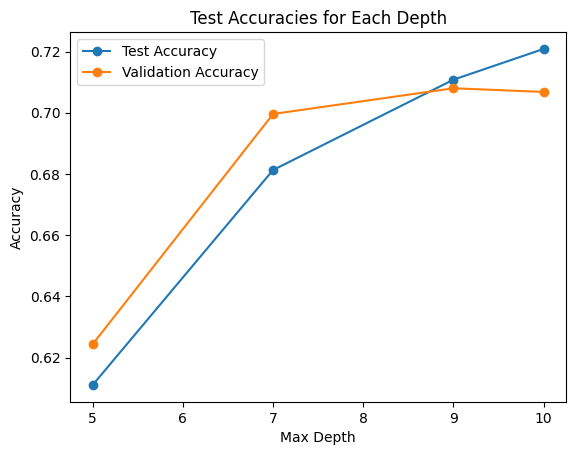

In [12]:
cv_results = grid_search.cv_results_
depths = param_grid['max_depth']
test_accuracies = cv_results['mean_test_score']

# Plot the training and validation accuracies for each depth
plt.plot(depths, test_accuracies, 'o-', label='Test Accuracy')
plt.plot(depths, val_accuracies, 'o-', label='Validation Accuracy')

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Test Accuracies for Each Depth')
plt.legend()
plt.show()

<hr style="border: 2px solid;">

<h3 align="center"> CLASSIFICATION REPORT

In [13]:
cat_list = ["Lung Adenocarcinoma",
"Lung Benign Tissue",
"Lung Squamous Cell Carcinoma",
"Colon Benign Tissue",
"Colon Adenocarcinoma"]
original_classes = [cat_list[i] for i in testY]
Y_test = [cat_list[i] for i in y_test_pred]
report = classification_report(original_classes, Y_test,zero_division=0)
print(report)

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.68      0.83      0.74       500
         Colon Benign Tissue       0.99      0.91      0.95       500
         Lung Adenocarcinoma       0.60      0.54      0.57       500
          Lung Benign Tissue       0.64      0.70      0.67       500
Lung Squamous Cell Carcinoma       0.68      0.58      0.63       500

                    accuracy                           0.71      2500
                   macro avg       0.72      0.71      0.71      2500
                weighted avg       0.72      0.71      0.71      2500



<hr style="border: 2px solid;">

<h3 align="center"> CONFUSION MATRIX

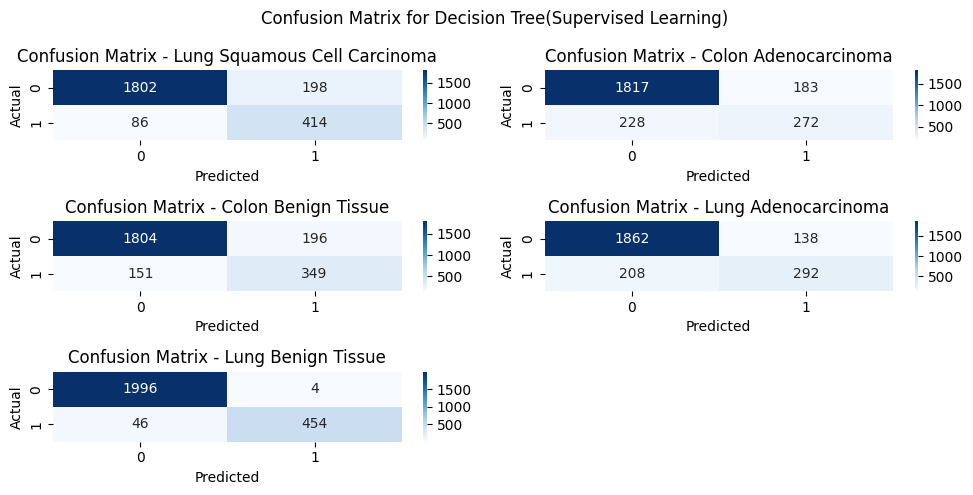

In [14]:
cnf_matrix = multilabel_confusion_matrix(testY, y_test_pred)
np.set_printoptions(precision=2)
num_labels = len(cnf_matrix)

# Calculate the number of rows and columns needed based on the available labeled data
num_rows = (num_labels+1) // 2
num_cols = min(2, num_labels)

# Plotting the confusion matrix
fig, axes = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(10, 5))
labels = list(test_generator.class_indices.keys()) # Replace with your label names

for i,ax in enumerate(axes.flat):
    if i < num_labels:
        sns.heatmap(cnf_matrix[i-1], annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix - {labels[i-1]}')
    else:
        # Remove any unused subplots
        fig.delaxes(ax)

plt.suptitle("Confusion Matrix for Decision Tree(Supervised Learning)")
plt.tight_layout()
plt.show()

<hr style="border: 2px solid;">

<h3 align="center"> PCA and T-SNE

In [15]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(testX)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
df['y'] = testY
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.27 0.06 0.01]


Text(0.5, 1.0, 'PCA')

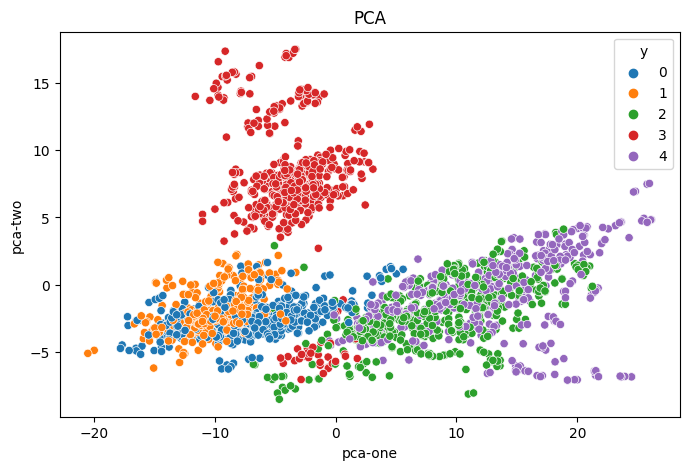

In [16]:
rndperm = np.random.permutation(testX.shape[0])
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10",5),
    data=df.loc[rndperm,:],
    legend="full",
)
plt.title("PCA")

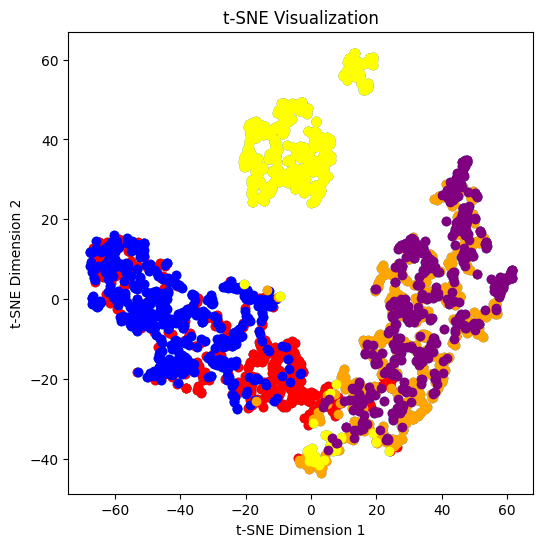

In [17]:
tsne = TSNE(n_components=2)
tsne_values = tsne.fit_transform(pca_result)

# Extract x and y coordinates from t-SNE values
x = tsne_values[:, 0]
y = tsne_values[:, 1]

# Create a scatter plot of the t-SNE graph
plt.figure(figsize=(6, 6))
plt.scatter(x, y)

# Add labels or color based on your dataset
labels = df['y']  # Replace with your labels or class information
unique_labels = np.unique(labels)
num_labels = len(unique_labels)
colors = ["red","blue","orange","yellow","purple","cyan"] * (num_labels // 5 + 1)

for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)
    plt.scatter(x[indices], y[indices], color=colors[i], label=label)


plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

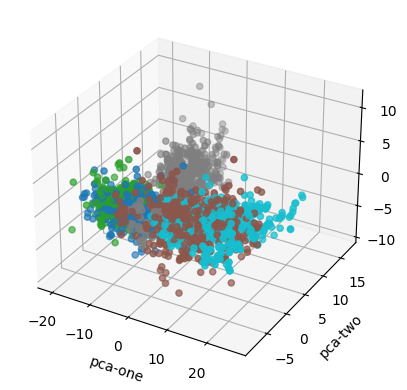

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [19]:
joblib.dump(best_model, "DecisionTree.pkl")

['DecisionTree.pkl']